In [2]:
! pip install openpiv


     |████████████████████████████████| 45.4MB 97kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 36.2MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
  Created wheel for openpiv: filename=OpenPIV-0.22.3-cp36-cp36m-linux_x86_64.whl size=46038508 sha256=e0b9d1f262000cfaefb97c6f8d1636b86ade8a670420d9cd654ecc0354737885
  Stored in directory: /root/.cache/pip/wheels/cc/0d/38/e833aa30da0de560418da5253ba88ae0782f38a4300b912ad3
Successfully built openpiv


Sol 1)

 Frame A => 
 [[42000 12000 30000 ... 18000 30000 24000]
 [24000 18000 24000 ... 18000 24000 18000]
 [24000 30000 24000 ... 24000 24000 12000]
 ...
 [18000 18000 12000 ... 18000 24000 30000]
 [36000 24000 24000 ... 18000 36000 24000]
 [42000 24000 24000 ... 18000 30000 18000]]


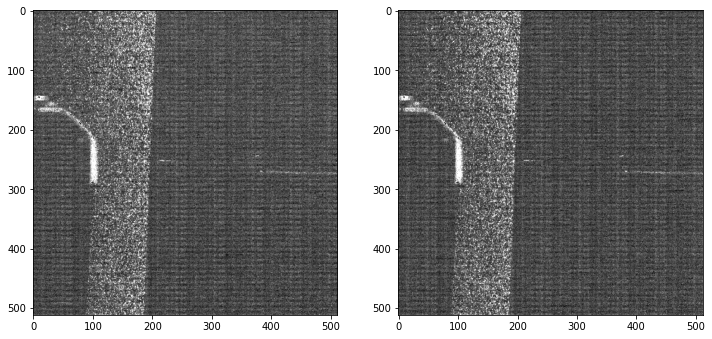

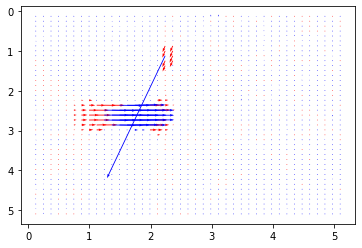

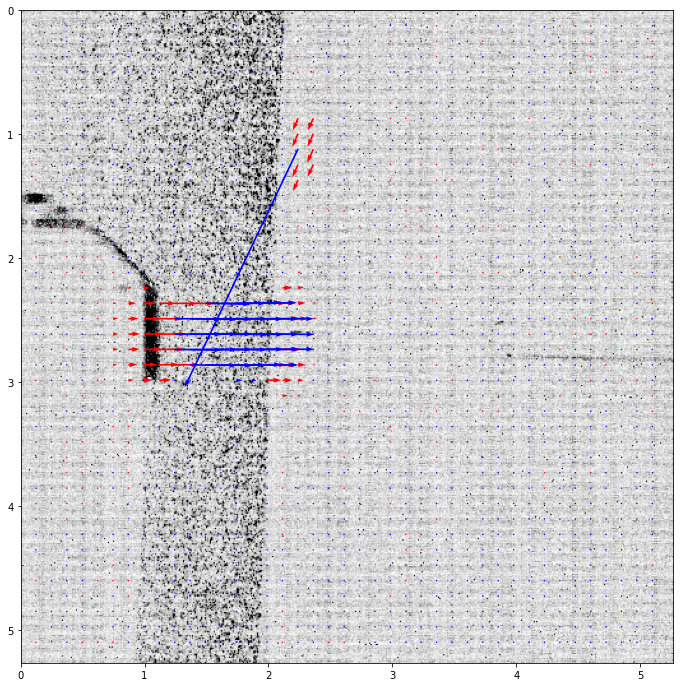

In [3]:
from openpiv import tools, process, validation, filters, scaling 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import imageio

frame_a  = tools.imread( '/content/B00001.png' )
frame_b  = tools.imread( '/content/B00002.png' )

print(" Frame A => \n",frame_a)


fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)



winsize = 24 # pixels
searchsize = 64  # pixels, search in image B
overlap = 12 # pixels
dt = 0.02 # sec


u0, v0, sig2noise = process.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method='peak2peak' )
# OpenPIV function responsible for convultaional analysis of the entire image using a search window


x, y = process.get_coordinates( image_size=frame_a.shape, window_size=winsize, overlap=overlap )
# OpenPIV module that finds the center of the interrogation window


u1, v1, mask = validation.sig2noise_val( u0, v0, sig2noise, threshold = 1.3 )
# OpenPIV module that replaces fake vectors with 0 if below a certain threshhold


u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2)
# Invalid velocity vectors are replaced with a weighted average of neighbouring elements 
# that are not valid themselves. For the local mean method the kernel size is used to find
# the weighted average. If the surrounding elements are not valid then iterations are used 
# upto a point where variation in the region is below a certain threshold 


x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 96.52 )



tools.save(x, y, u3, v3, mask, 'exp1_001.txt' )
# saves flow field in an ascii file, masks invalid vectors


tools.display_vector_field('exp1_001.txt', scale=50, width=0.0025)



fig, ax = plt.subplots(figsize=(12,12))
tools.display_vector_field('exp1_001.txt', ax=ax, scaling_factor=96.52, scale=50, width=0.0025, on_img=True, image_name='/content/B00002.png');







Sol 2)

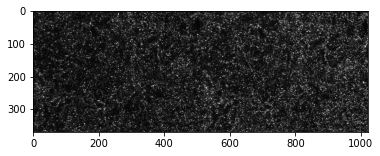

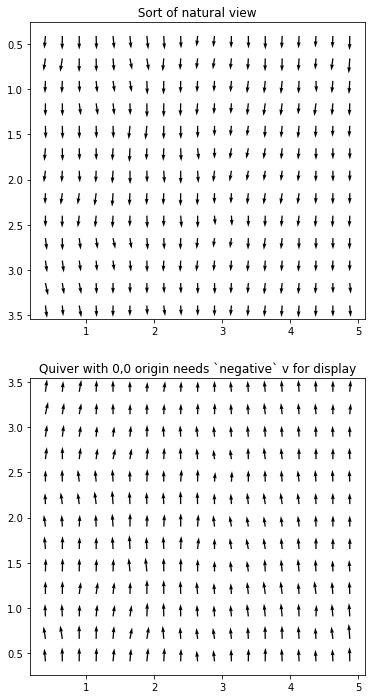

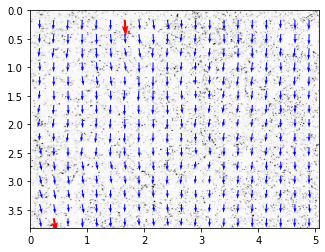

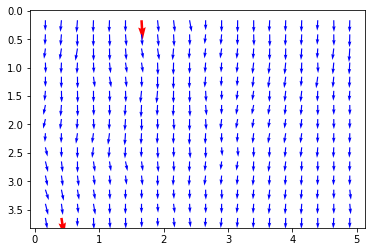

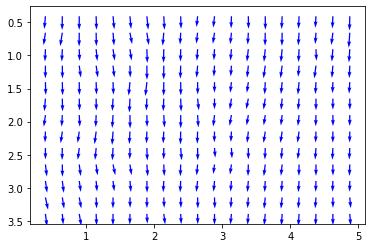

----------------------------------------------------------
|----->     ||   The Open Source  P article              |
| Open      ||                    I mage                 |
|     PIV   ||                    V elocimetry  Toolbox  |
|     <-----||   www.openpiv.net          version 1.0    |
----------------------------------------------------------
 
('Algorithm : ', 'WiDIM')
 
Parameters   
-----------------------------------
('     ', 'Size of image', ' | ', [369, 511])
('     ', 'total number of iterations', ' | ', 1)
('     ', 'overlap ratio', ' | ', 0.25)
('     ', 'coarse factor', ' | ', 0)
('     ', 'time step', ' | ', 0.10000000149011612)
('     ', 'validation method', ' | ', 'None')
('     ', 'number of validation iterations', ' | ', 0)
('     ', 'subpixel_method', ' | ', 'gaussian')
('     ', 'Nrow', ' | ', array([15], dtype=int32))
('     ', 'Ncol', ' | ', array([20], dtype=int32))
('     ', 'Window sizes', ' | ', array([32], dtype=int32))
--------------------------------

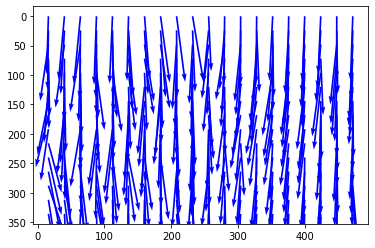

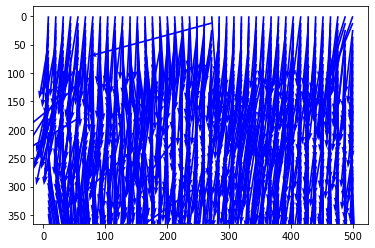

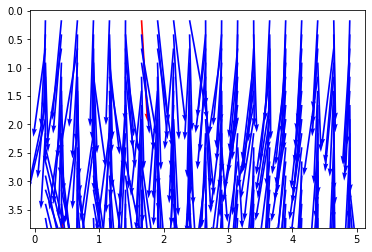

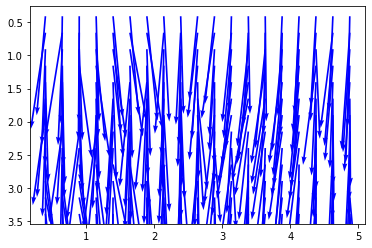

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fece6393fd0>)

In [5]:
# %load red_Cell.py
from openpiv import tools, pyprocess, scaling, filters, \
                    validation, process
import numpy as np
import matplotlib.pyplot as plt

import imageio
from pylab import *
%matplotlib inline

from skimage import img_as_uint

frame_a  = tools.imread('/content/pic1.bmp')  
frame_b  = tools.imread('/content/pic2.bmp')

plt.imshow(np.c_[frame_a,frame_b],cmap=plt.cm.gray)


# Use Cython version: process.pyx

u, v, sig2noise = process.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=32, overlap=8, dt=.1,search_area_size=64, sig2noise_method='peak2peak' )
x, y = process.get_coordinates( image_size=frame_a.shape, window_size=32, overlap=8 )

u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.3 )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )

tools.save(x, y, u, v, mask, 'Y4-S3_Camera000398_a.txt' )


# Use Python version, pyprocess:

u, v, sig2noise = pyprocess.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=32, overlap=8, dt=.1,search_area_size=64, sig2noise_method='peak2peak' )
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, window_size=32, overlap=8,search_area_size=64 )
u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.3 )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )

tools.save(x, y, u, v, mask, 'Y4-S3_Camera000398_b.txt' )

# "natural" view without image
fig,ax = plt.subplots(2,1,figsize=(6,12))
ax[0].invert_yaxis()
ax[0].quiver(x,y,u,v)
ax[0].set_title(' Sort of natural view ')

ax[1].quiver(x,y,u,-v)
ax[1].set_title('Quiver with 0,0 origin needs `negative` v for display');
# plt.quiver(x,y,u,v)



tools.display_vector_field('Y4-S3_Camera000398_a.txt',on_img=True,image_name='/content/pic1.bmp',scaling_factor=96.52)



tools.display_vector_field('Y4-S3_Camera000398_a.txt')



tools.display_vector_field('Y4-S3_Camera000398_b.txt')

x,y,u,v, mask = process.WiDIM(frame_a.astype(np.int32), frame_b.astype(np.int32), ones_like(frame_a).astype(np.int32), min_window_size=32, overlap_ratio=0.25, coarse_factor=0, dt=0.1, validation_method='mean_velocity', trust_1st_iter=0, validation_iter=0, tolerance=0.7, nb_iter_max=1, sig2noise_method='peak2peak')



tools.save(x, y, u, v, zeros_like(u), 'Y4-S3_Camera000398_widim1.txt' )

x,y,u,v, mask = process.WiDIM(frame_a.astype(np.int32), frame_b.astype(np.int32), ones_like(frame_a).astype(np.int32), min_window_size=16, overlap_ratio=0.25, coarse_factor=2, dt=0.1, validation_method='mean_velocity', trust_1st_iter=1, validation_iter=2, tolerance=0.7, nb_iter_max=4, sig2noise_method='peak2peak')




tools.save(x, y, u, v, zeros_like(u), 'Y4-S3_Camera000398_widim2.txt' )

tools.display_vector_field('Y4-S3_Camera000398_widim1.txt', widim=True, scale=300, width=0.005)
tools.display_vector_field('Y4-S3_Camera000398_widim2.txt', widim=True, scale=300, width=0.005)
tools.display_vector_field('Y4-S3_Camera000398_a.txt', scale=2, width=0.005,scaling_factor=96.52)
tools.display_vector_field('Y4-S3_Camera000398_b.txt', scale=2, width=0.005,scaling_factor=96.52)


sol 3)

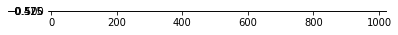

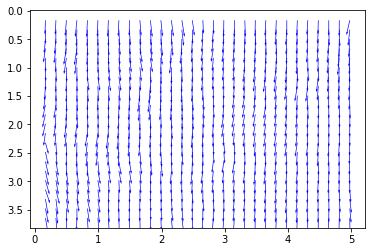

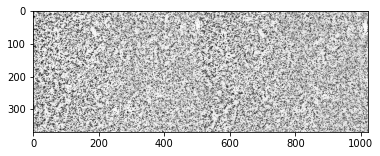

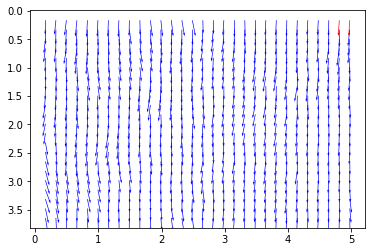

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fece23ee668>)

In [6]:
from openpiv import tools, pyprocess, scaling, filters, \
                    validation, process, preprocess
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline



file_a = '/content/pic1.bmp'
file_b = '/content/pic2.bmp'

im_a  = tools.imread( file_a )
im_b  = tools.imread( file_b )
plt.imshow(np.c_[im_a,im_b],cmap='gray')


# let's crop the region of interest
frame_a =  im_a[380:1980,0:1390]
frame_b =  im_b[380:1980,0:1390]
plt.imshow(np.c_[frame_a,frame_b],cmap='gray')




# typical parameters:
window_size = 32 #pixels
overlap = 16 # pixels
search_area_size = 24 # pixels 
frame_rate = 40 # fps

# process again with the masked images, for comparison# process once with the original images
u, v, sig2noise = process.extended_search_area_piv(
                                                       im_a.astype(np.int32) , im_b.astype(np.int32), 
                                                       window_size = window_size,
                                                       overlap = overlap, 
                                                       dt=1./frame_rate, 
                                                       search_area_size = 32, 
                                                       sig2noise_method = 'peak2peak')
x, y = process.get_coordinates( image_size = im_a.shape, window_size = window_size, overlap = overlap )
u, v, mask = validation.global_val( u, v, (-300.,300.),(-300.,300.))
u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.1 )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter = 3, kernel_size = 3)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
# save to a file
tools.save(x, y, u, v, mask, 'test.txt', fmt='%9.6f', delimiter='\t')
tools.display_vector_field('test.txt', scale=50, width=0.002)



# masking using not optimal choice of the methods or parameters:
masked_a = preprocess.dynamic_masking(im_a,method='edges',filter_size=7,threshold=0.005)
masked_b = preprocess.dynamic_masking(im_b,method='intensity',filter_size=3,threshold=0.0)
plt.imshow(np.c_[masked_a,masked_b],cmap='gray')

# masking using optimal (manually tuned) set of parameters and the right method:
masked_a = preprocess.dynamic_masking(im_a,method='edges',filter_size=7,threshold=0.01)
masked_b = preprocess.dynamic_masking(im_b,method='edges',filter_size=7,threshold=0.01)
plt.imshow(np.c_[masked_a,masked_b],cmap='gray')

# Process the masked cropped image and see the OpenPIV result:

# process again with the masked images, for comparison# process once with the original images
u, v, sig2noise = process.extended_search_area_piv(
                                                       masked_a.astype(np.int32) , masked_b.astype(np.int32), 
                                                       window_size = window_size,
                                                       overlap = overlap, 
                                                       dt=1./frame_rate, 
                                                       search_area_size = 32, 
                                                       sig2noise_method = 'peak2peak')
x, y = process.get_coordinates( image_size = masked_a.shape, window_size = window_size, overlap = overlap )
u, v, mask = validation.global_val( u, v, (-300.,300.),(-300.,300.))
u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.1)
u, v = filters.replace_outliers( u, v, method='localmean', max_iter = 3, kernel_size = 3)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
# save to a file
tools.save(x, y, u, v, mask, 'test_masked.txt', fmt='%9.6f', delimiter='\t')
tools.display_vector_field('test_masked.txt', scale=50, width=0.002)





Sol 4)

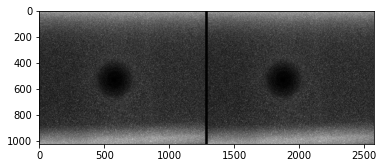

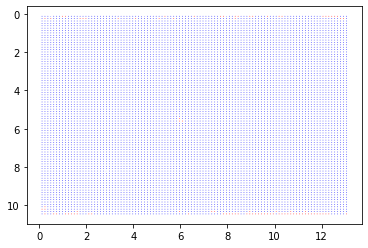

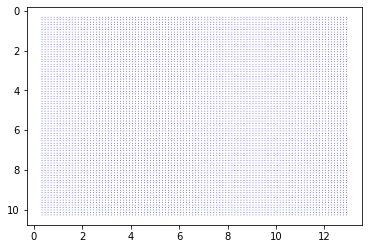

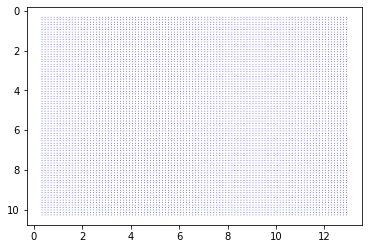

In [7]:
from openpiv import tools, process, scaling, pyprocess, validation, filters
import numpy as np
import pylab
%matplotlib inline



frame_a  = tools.imread( '/content/A001_1.tif' )
frame_b  = tools.imread( '/content/A001_1 (1).tif' )
pylab.imshow(np.c_[frame_a,np.ones((frame_a.shape[0],20)),frame_b],cmap=pylab.cm.gray)

##time
u, v, sig2noise = process.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=24, overlap=12, dt=0.02, search_area_size=64, sig2noise_method='peak2peak' )
x, y = process.get_coordinates( image_size=frame_a.shape, window_size=24, overlap=12 )
u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 2.5 )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
tools.save(x, y, u, v, mask, 'exp2_001_extended.txt' )

##time
u, v, sig2noise = pyprocess.extended_search_area_piv( frame_a, frame_b, corr_method='fft', window_size=24, overlap=12, dt=0.02, search_area_size=64, sig2noise_method='peak2peak' )
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, window_size=24, overlap=12, search_area_size=64 )
u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 2.5 )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
tools.save(x, y, u, v, mask, 'exp3_001_fft.txt' )

##time 
u, v, sig2noise = pyprocess.extended_search_area_piv( frame_a, frame_b, corr_method='direct', window_size=24, overlap=12, dt=0.02, search_area_size=64, sig2noise_method='peak2peak' )
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, window_size=24, overlap=12,search_area_size=64 )
u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 2.5 )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
tools.save(x, y, u, v, mask, 'exp4_001_direct.txt' )



tools.display_vector_field('exp2_001_extended.txt', scale=30, width=0.0025)
tools.display_vector_field('exp3_001_fft.txt', scale=30, width=0.0025)
tools.display_vector_field('exp4_001_direct.txt', scale=30, width=0.0025);

